# Get local object tilts

- Created with PtyRAD 0.1.0b12
- Requires PtyRAD >= 0.1.0b8
- Latest demo params files / scripts: https://github.com/chiahao3/ptyrad/tree/main/demo
- Documentation: https://ptyrad.readthedocs.io/en/latest/
- PtyRAD paper: https://doi.org/10.1093/mam/ozaf070
- PtyRAD arXiv: https://arxiv.org/abs/2505.07814
- Zenodo record: https://doi.org/10.5281/zenodo.15273176
- Box folder: https://cornell.box.com/s/n5balzf88jixescp9l15ojx7di4xn1uo
- Youtube channel: https://www.youtube.com/@ptyrad_official

**Before running this notebook, you must first follow the instruction in `README.md` to:**
1. Create the Python environment with all dependant Python packages like PyTorch
2. Activate that python environment
3. Install `ptyrad` package into your activated Python environement (only need to install once)

> Note: This notebook is designed for estimating position-dependent object tilt

Author: Chia-Hao Lee, cl2696@cornell.edu

STO data credit: Dr. Hongbin Yang, hy643@cornell.edu

## Notes about object tilt
- Object tilt != beam tilt, because the latter has strong influence to aberrations.
- In practice, object tilt is often simulated with a tilted propagator, see Kirkland eqn. 6.99, 2010 edition.
- This tilted propagator is equivalent to shifted slices for small angles (i.e., 1-5 deg), see Cowley JM (1975) Diffraction physics, 2nd edn.
  - Fundamentally, electron waves would be attracted by nuclei even they're laterally shifted. This gives exactly the channeling effect. 
- Incorporating object tilt into ptycho reconstruction does NOT really "remove" the tilt, it is more of a tilted view of the reconstructed object by moving tilt from the object to the propagator.
  - Experimental pattern with obj tilt can be reconstructed either as:
    1. Straight-down propagator + object with shifted slices
    2. Tilted propagator + object with aligned slices
- Due to the thick slices (i.e., 1 nm), incorporating tilt into the propagator could potentially reduce the reconstructed atomic column width (simple projection trigonometry)
- If you apply position-dependent tilt, it is essentially bending the object grid non-uniformly, so technically the px size becomes position dependent as well.
  - Depends on the amount of the tilt, this position-dependent-tilt-induced object distortion could be up to a few to 10 pm so treat it carefully if you want to do detailed strcutural analysis
- Not much we can do if the obj tilt is changing along the beam propagation direction (i.e, bended specimen)
- In practice you can estimate the global object tilt from PACBED or Kikuchi pattern, and often times PtyRAD can handle object tilt just fine by reconstructing into shifted slices.
- Although estimating obj tilts from shifted slices is quite accurate, it requires a successful multislice ptycho reconstructions. For a quick alternative, you can run a sliding window PACBED to estimate pos-dependent tilts as well.
- For position-dependent tilt, it is strongly recommended to provide initial guess with this notebook or other methods.

## 00. Setup working directory and imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.feature import blob_log
from scipy.ndimage import center_of_mass
from scipy.interpolate import griddata
from scipy.optimize import curve_fit

from ptyrad.load import load_ptyrad
from ptyrad.save import save_array

# Set this to your desired working directory so you can easily access the data, model, param files
work_dir = "H:/workspace/ptyrad/demo/"

os.chdir(work_dir)
print("Current working dir: ", os.getcwd())
# Note that the output/ directory will be automatically generated under your working directory

Current working dir:  H:\workspace\ptyrad\demo


## 01. Load the 3D image stack

Success! Loaded .hdf5 file as a dict from path = 'H:/workspace/ptyrad_work/output/Hongbin_STO_16/20250923_full_N4096_dp128_sparse32_p4_1obj_30slice_dz10_plr1e-4_oalr5e-4_oplr5e-4_slr5e-4_dpblur1.0_orblur0.4_ozblur1.0_oathr0.95_oposc_sng1.0_spr0.1/model_iter0200.hdf5'


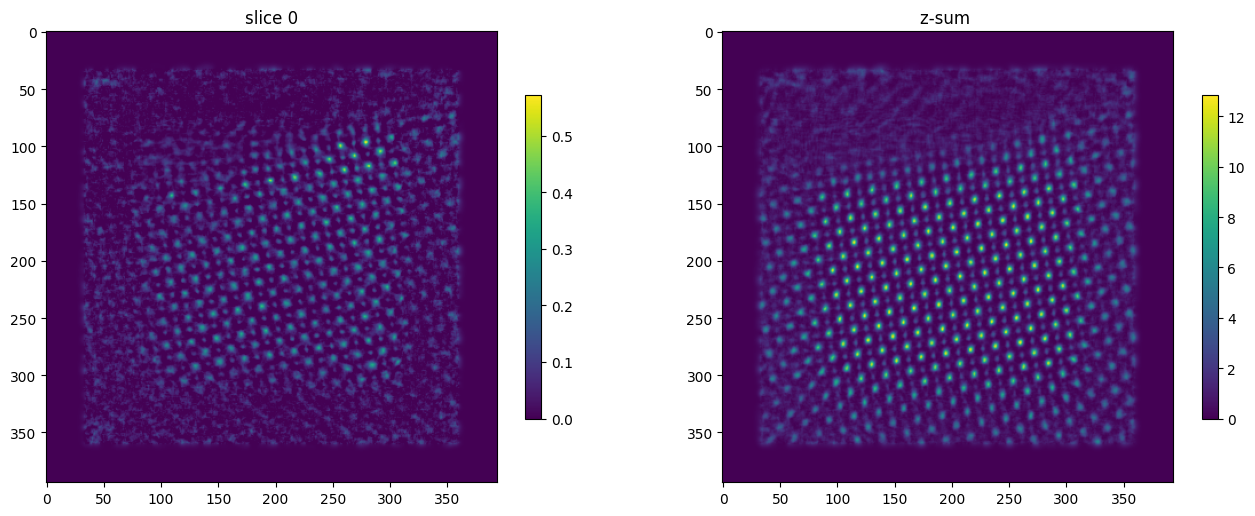

In [2]:
model_path = "H:/workspace/ptyrad_work/output/Hongbin_STO_16/20250923_full_N4096_dp128_sparse32_p4_1obj_30slice_dz10_plr1e-4_oalr5e-4_oplr5e-4_slr5e-4_dpblur1.0_orblur0.4_ozblur1.0_oathr0.95_oposc_sng1.0_spr0.1/model_iter0200.hdf5"
ckpt = load_ptyrad(model_path)
dx = ckpt['model_attributes']['dx']
slice_thickness = ckpt['optimizable_tensors']['slice_thickness']
imstack = ckpt['optimizable_tensors']['objp'].sum(0) # objp (omode, Nz, Ny, Nx) so we first reduce the omode dimension
Npix = ckpt['optimizable_tensors']['probe'].shape[-1] # Probe window size

# Plot the selected slice and z-sum
idx = 0
fig, axs = plt.subplots(1,2, figsize=(16,6))
im0 = axs[0].imshow(imstack[idx])
im1 = axs[1].imshow(imstack.sum(0))

axs[0].set_title(f"slice {idx}")
axs[1].set_title("z-sum ")

fig.colorbar(im0, shrink=0.7)
fig.colorbar(im1, shrink=0.7)
plt.show()

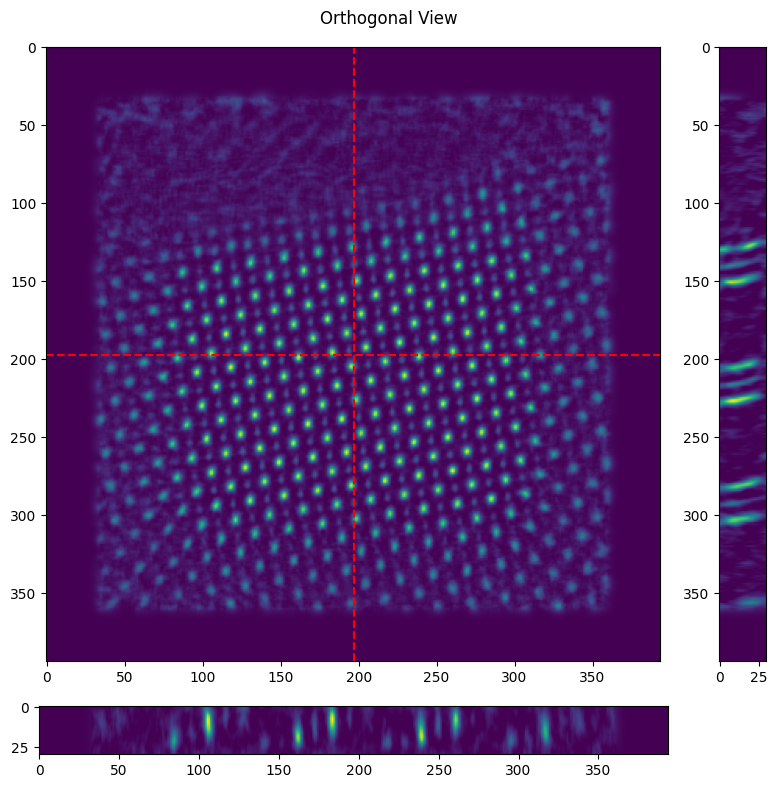

In [3]:
# Plot the orthogonal view, obj tilt is visualized by the slanted atomic column along depth dimension
ortho_view = (imstack.shape[-2]//2, imstack.shape[-1]//2) # y, x in object pixel
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1,0.1], height_ratios=[1,0.1])

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])

im0 = ax0.imshow(imstack.sum(0), aspect='equal')
im1 = ax1.imshow(imstack[:, :, ortho_view[1]].T, aspect='equal')
im2 = ax2.imshow(imstack[:, ortho_view[0], :], aspect='equal')

ax0.axhline(ortho_view[0], color='red', linestyle='--')
ax0.axvline(ortho_view[1], color='red', linestyle='--')

plt.suptitle('Orthogonal View')
plt.tight_layout()
plt.show()

## 02. Extract atom locations from targeted slices

The height difference between slices (5, 25) is 200.00 Ang
Found 159 blobs with mean radius of 2.38 px or 0.45 Ang


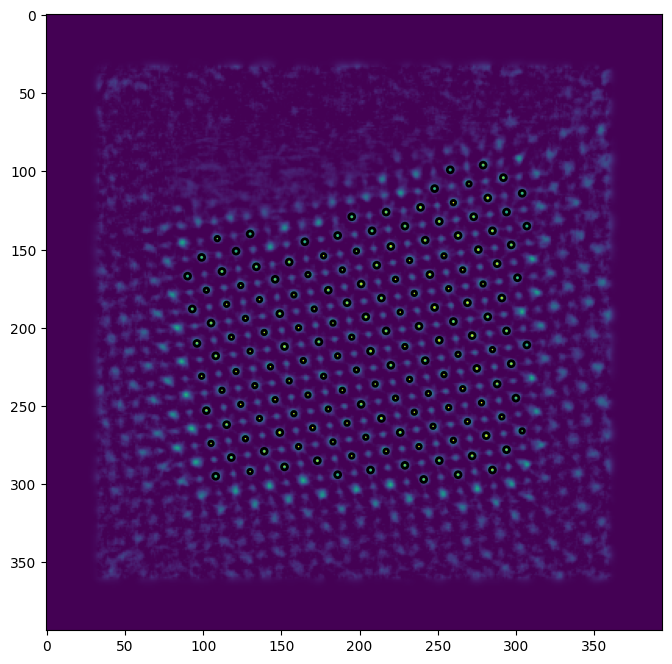

In [4]:
# Choose the 2 slices from imstack
slice_t = 5
slice_b = 25
height = (slice_b - slice_t)*slice_thickness
print(f"The height difference between slices {(slice_t, slice_b)} is {height:.2f} Ang")
target_stack = imstack[[slice_t,slice_b]]

# Adjust Blob detection parameters accordingly, see: https://scikit-image.org/docs/0.25.x/api/skimage.feature.html#skimage.feature.blob_log
blobs = blob_log(target_stack[0], min_sigma=1, max_sigma=5, overlap=0.1, threshold = 0.20, exclude_border=(Npix//2, Npix//2)) 
print(f"Found {len(blobs)} blobs with mean radius of {1.414*blobs.mean(0)[-1]:.2f} px or {dx*1.414*blobs.mean(0)[-1]:.2f} Ang")

# Plot the detected blobs
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(target_stack[0])
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, linewidth=2, fill=False)
    ax.add_patch(c)
plt.show()

## 03. Extend blob detection to all intermediate slices

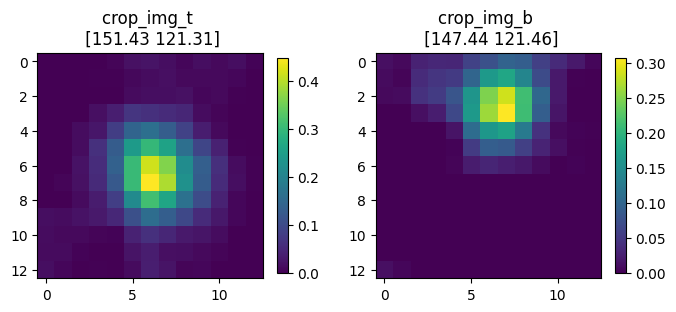

In [5]:
window_size = 13 # Ideally the window should contain only 1 lattice point (i.e., 1 atomic column or 1 pair of dumbells)

row_start = np.uint32(blobs[:,0]-window_size//2)
row_end   = np.uint32(blobs[:,0]+window_size//2+1)

col_start = np.uint32(blobs[:,1]-window_size//2)
col_end   = np.uint32(blobs[:,1]+window_size//2+1)

coord_t   = np.zeros((len(blobs),2))
coord_b   = np.zeros((len(blobs),2))

for i in range(len(blobs)):
    crop_img_t = target_stack[0][row_start[i]:row_end[i], col_start[i]:col_end[i]]
    crop_img_b = target_stack[1][row_start[i]:row_end[i], col_start[i]:col_end[i]]
    coord_t[i] = center_of_mass(crop_img_t) + blobs[i,:-1] - window_size//2
    coord_b[i] = center_of_mass(crop_img_b) + blobs[i,:-1] - window_size//2

shift_vecs = coord_b - coord_t # This is the needed tilt to correct the obj tilt so it's pointing from top to bottom

# Plot the cropped window for CoM fitting
fig, axs = plt.subplots(1,2, figsize=(8,4))
im0 = axs[0].imshow(crop_img_t)
im1 = axs[1].imshow(crop_img_b)

axs[0].set_title(f"crop_img_t \n {coord_t[-1].round(2)}")
axs[1].set_title(f"crop_img_b \n {coord_b[-1].round(2)}")

fig.colorbar(im0, shrink=0.7)
fig.colorbar(im1, shrink=0.7)
plt.show()

## 04. Plot the position-dependent tilt vectors

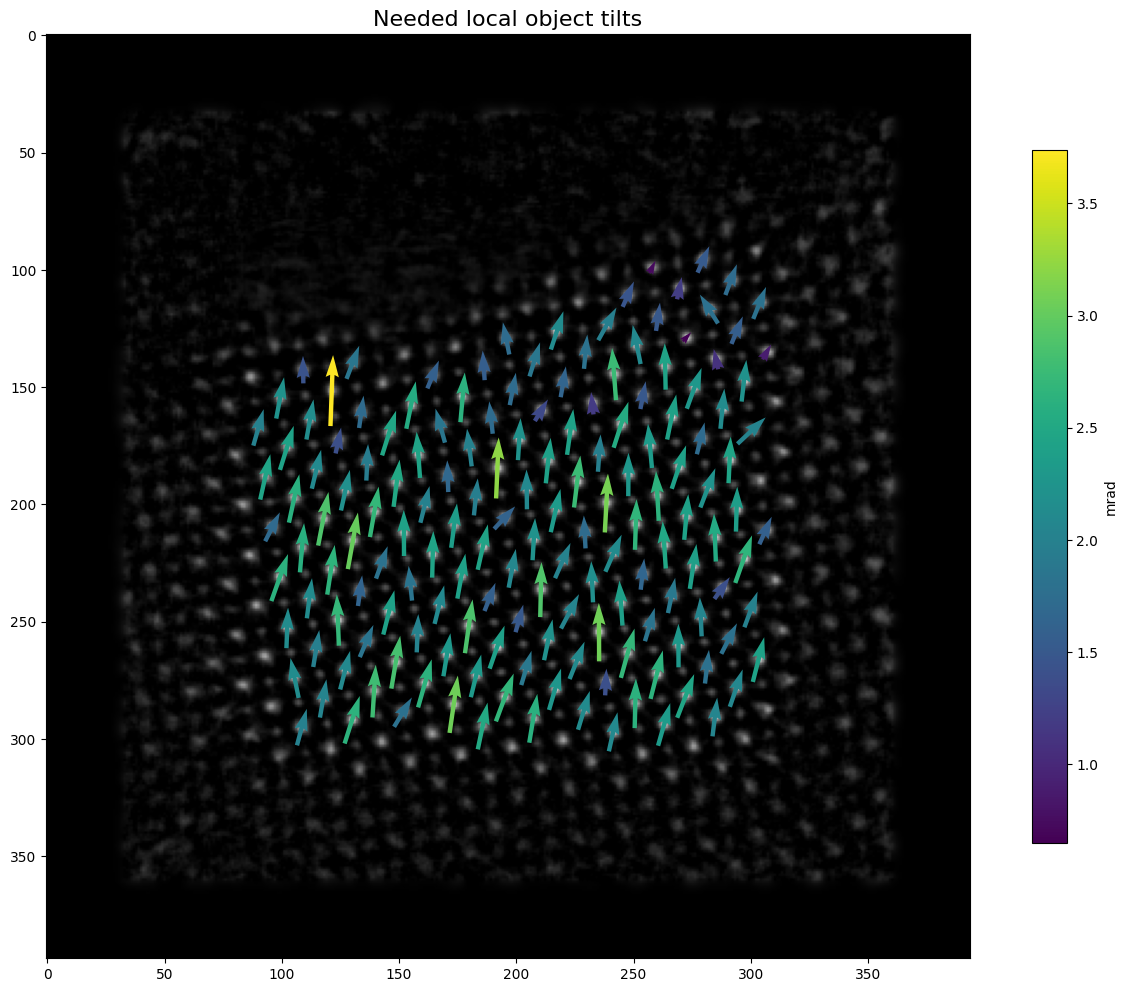

In [6]:
# Plot the tilt vectors
X = coord_t[:,1]
Y = coord_t[:,0]
U = shift_vecs[:,1]
V = shift_vecs[:,0]
M = np.arctan(np.hypot(U,V)*dx/height)*1e3

fig, ax = plt.subplots(figsize=(16,12))
plt.title("Needed local object tilts", fontsize=16)
ax.imshow(target_stack[0], cmap='gray')
q = ax.quiver(X, Y, U, V, M, pivot='mid', angles='xy', scale_units='xy')
cbar = fig.colorbar(q, shrink=0.75)
cbar.ax.set_ylabel('mrad')
plt.show()

## 05. Interpolate the tilt vectors into tilt field

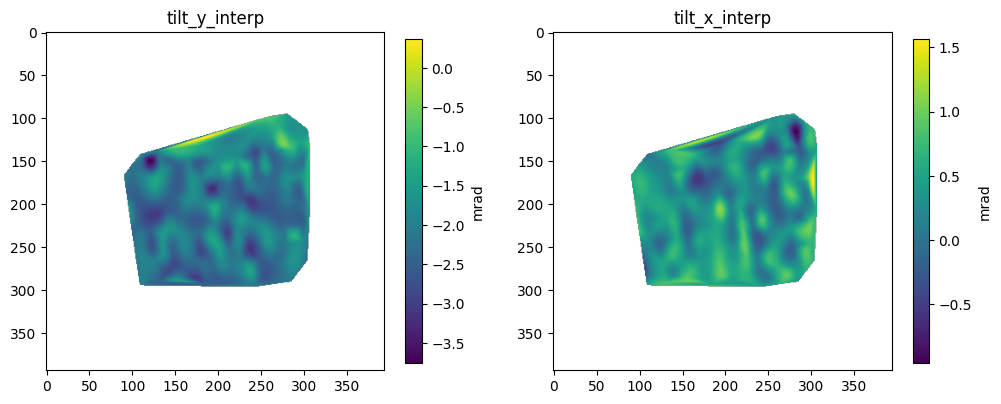

tilt_y (min, mean, max) = (-3.74, -2.08, -0.48) mrad
tilt_x (min, mean, max) = (-0.96, 0.36, 1.48) mrad


In [7]:
# Do the interpolation with griddata
tilt_y = np.arctan(V*dx/height)*1e3
tilt_x = np.arctan(U*dx/height)*1e3

#Interpolate tilt_y, tilt_x map
xnew, ynew= np.mgrid[0:target_stack.shape[-2]:1, 0:target_stack.shape[-1]:1]
tilt_y_interp = griddata(np.stack([Y,X], -1), tilt_y ,(xnew, ynew), method='cubic')
tilt_x_interp = griddata(np.stack([Y,X], -1), tilt_x ,(xnew, ynew), method='cubic')

# Plot the interpolated tilt field
fig, axs = plt.subplots(1,2, figsize=(12,6))
im0=axs[0].imshow(tilt_y_interp)
im1=axs[1].imshow(tilt_x_interp)
axs[0].set_title("tilt_y_interp")
axs[1].set_title("tilt_x_interp")
cbar0 = fig.colorbar(im0, shrink=0.7)
cbar0.ax.set_ylabel('mrad')
cbar1 = fig.colorbar(im1, shrink=0.7)
cbar1.ax.set_ylabel('mrad')
plt.show()

# Print some basic statistics
print(f"tilt_y (min, mean, max) = {(tilt_y.min().round(2).item(), tilt_y.mean().round(2).item(), tilt_y.max().round(2).item())} mrad")
print(f"tilt_x (min, mean, max) = {(tilt_x.min().round(2).item(), tilt_x.mean().round(2).item(), tilt_x.max().round(2).item())} mrad")

### Note:
If you want to directly plug in these values as a fixed global tilt correction, just modify your .yaml param file as:
```yaml
'tilt_params'            : {'tilt_type':'all', 'init_tilts':[[<TILT_Y>, <TILT_X>]]}
```
Replace <TILT_Y> and <TILT_X> with actual numerical values.

## 06. Fit again with simple polynomial surface to extrapolate the entire FOV 

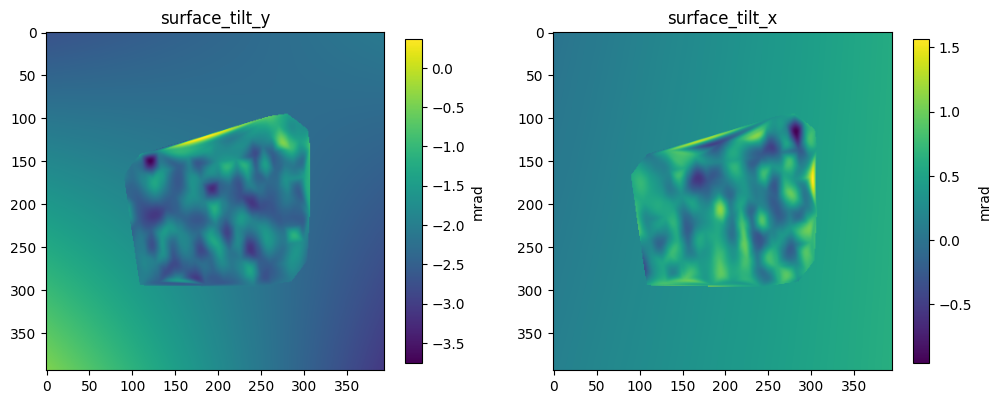

In [8]:
# Use curve_fit to extrapolate to the entire FOV

def surface_fn(t, a1, b1, c1, d):
    y,x = t
    return  a1*x + b1*y + c1*x*y + d

xdata = np.vstack((Y,X))
ydata_tilt_y = tilt_y
ydata_tilt_x = tilt_x
popt_tilt_y, _ = curve_fit(surface_fn, xdata, ydata_tilt_y)
popt_tilt_x, _ = curve_fit(surface_fn, xdata, ydata_tilt_x)

# Implanting griddata interpolated values into the fitted background
surface_tilt_y = surface_fn(np.stack((ynew,xnew)), *popt_tilt_y)
surface_tilt_x = surface_fn(np.stack((ynew,xnew)), *popt_tilt_x)

mask_tilt_y = ~np.isnan(tilt_y_interp)
surface_tilt_y[mask_tilt_y] = tilt_y_interp[mask_tilt_y]
mask_tilt_x = ~np.isnan(tilt_x_interp)
surface_tilt_x[mask_tilt_x] = tilt_x_interp[mask_tilt_x]

fig, axs = plt.subplots(1,2, figsize=(12,6))
im0=axs[0].imshow(surface_tilt_y)
im1=axs[1].imshow(surface_tilt_x)
axs[0].set_title("surface_tilt_y")
axs[1].set_title("surface_tilt_x")
cbar0 = fig.colorbar(im0, shrink=0.7)
cbar0.ax.set_ylabel('mrad')
cbar1 = fig.colorbar(im1, shrink=0.7)
cbar1.ax.set_ylabel('mrad')
plt.show()

## 07. Sample position-dependent tilts from the extrapolated tilt field

In [9]:
# Get the actual probe position on object
pos = ckpt['model_attributes']['crop_pos'] + ckpt['optimizable_tensors']['probe'].shape[-1]//2
pos

array([[ 97,  97],
       [ 97, 100],
       [ 97, 103],
       ...,
       [297, 291],
       [297, 294],
       [297, 297]], dtype=int32)

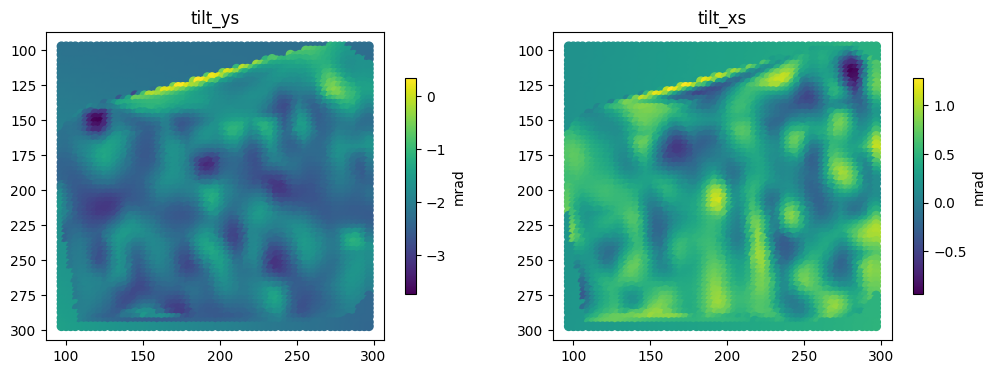

In [10]:
# Sample the surface with our probe position
tilt_ys = surface_tilt_y[pos[:,0], pos[:,1]]
tilt_xs = surface_tilt_x[pos[:,0], pos[:,1]]
obj_tilts = np.stack([tilt_ys, tilt_xs], axis=-1)

fig, axs = plt.subplots(1,2, figsize=(12,4))
im0=axs[0].scatter(x=pos[:,1], y=pos[:,0], c=obj_tilts[:,0])
im1=axs[1].scatter(x=pos[:,1], y=pos[:,0], c=obj_tilts[:,1])
axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].set_title("tilt_ys")
axs[1].set_title("tilt_xs")
cbar0 = fig.colorbar(im0, shrink=0.7)
cbar0.ax.set_ylabel('mrad')
cbar1 = fig.colorbar(im1, shrink=0.7)
cbar1.ax.set_ylabel('mrad')
plt.show()

## 08. Save the estimated pos-dependent obj tilt to disk

In [11]:
save_array(obj_tilts, file_dir='H:/workspace/ptyrad/demo/', file_name='obj_tilts', file_format='hdf5', append_shape=True, dataset_name='obj_tilts')

Saving array with shape = (4096, 2) and dtype = float64
file path = 'H:/workspace/ptyrad/demo/obj_tilts_4096_2.hdf5' already exists, the file will be overwritten.
Success! Saved data as 'obj_tilts' to .hdf5 file: H:/workspace/ptyrad/demo/obj_tilts_4096_2.hdf5


### Note:
To load the estimated pos-dependent obj tilt into PtyRAD, just modify your .yaml param file as:
```yaml
'tilt_source'            : 'file',
'tilt_params'            : {'path': '<FILE_PATH>', 'key': 'obj_tilts'},
```
Replace <FILE_PATH> with actual path string that points to your saved tilt file.

## 09. Reconstruct again with corrected obj tilt
The slanted atomic column is now mostly stright, and the object z-sum is now much sharper after the tilt correction.

Success! Loaded .hdf5 file as a dict from path = 'H:/workspace/ptyrad_work/output/Hongbin_STO_16/20250923_full_N4096_dp128_sparse32_p4_1obj_30slice_dz10_plr1e-4_oalr5e-4_oplr5e-4_slr5e-4_dpblur1.0_orblur0.4_ozblur1.0_oathr0.95_oposc_sng1.0_spr0.1_tilt-2.4_0.27/model_iter0200.hdf5'


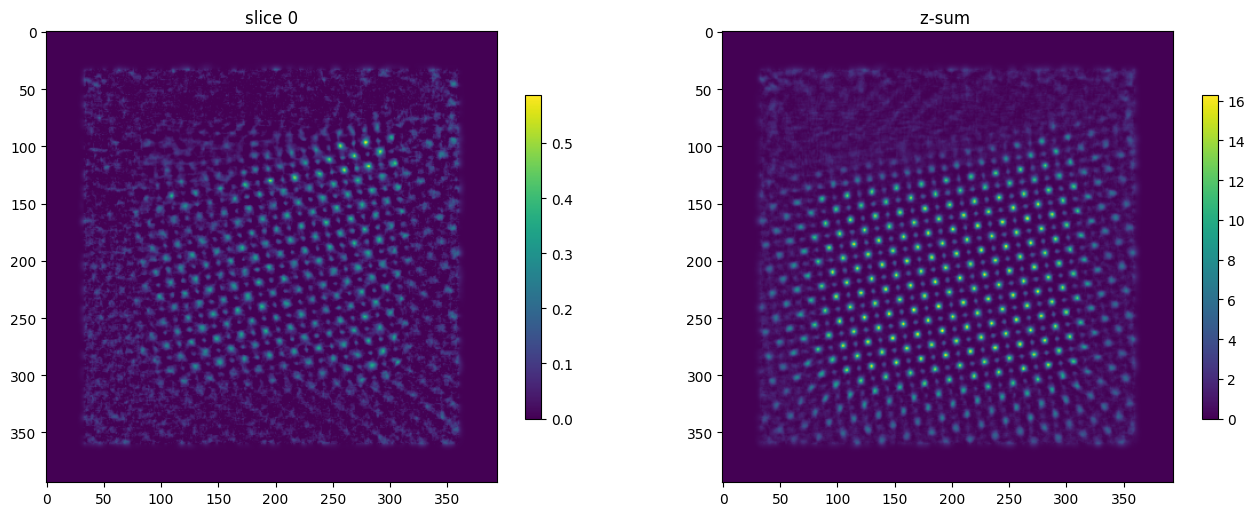

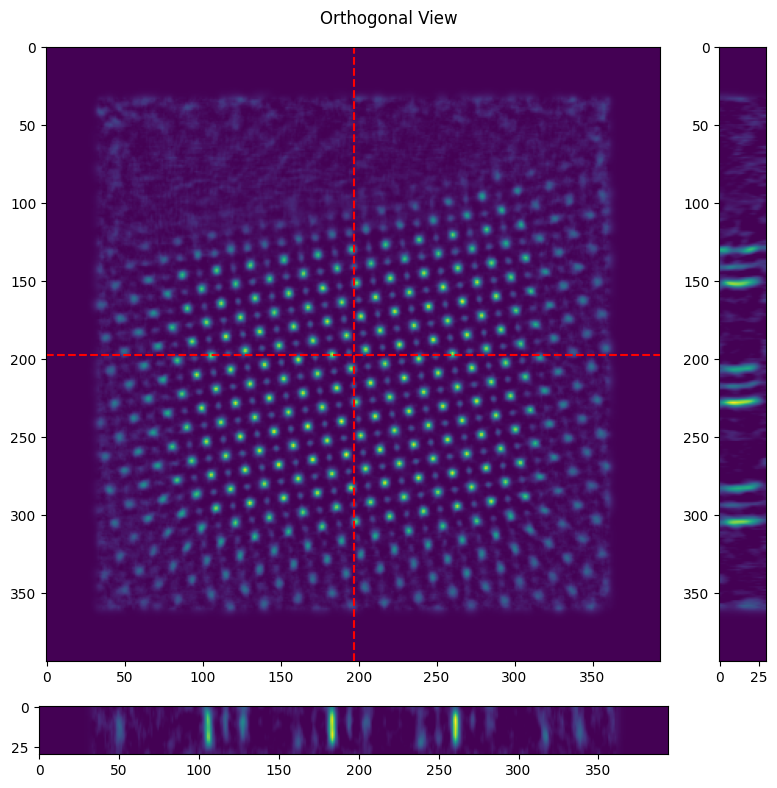

In [12]:
model_path = "H:/workspace/ptyrad_work/output/Hongbin_STO_16/20250923_full_N4096_dp128_sparse32_p4_1obj_30slice_dz10_plr1e-4_oalr5e-4_oplr5e-4_slr5e-4_dpblur1.0_orblur0.4_ozblur1.0_oathr0.95_oposc_sng1.0_spr0.1_tilt-2.4_0.27/model_iter0200.hdf5"
ckpt = load_ptyrad(model_path)
dx = ckpt['model_attributes']['dx']
slice_thickness = ckpt['optimizable_tensors']['slice_thickness']
imstack = ckpt['optimizable_tensors']['objp'].sum(0) # objp (omode, Nz, Ny, Nx) so we first reduce the omode dimension
Npix = ckpt['optimizable_tensors']['probe'].shape[-1] # Probe window size

# Plot the selected slice and z-sum
idx = 0
fig, axs = plt.subplots(1,2, figsize=(16,6))
im0 = axs[0].imshow(imstack[idx])
im1 = axs[1].imshow(imstack.sum(0))

axs[0].set_title(f"slice {idx}")
axs[1].set_title("z-sum ")

fig.colorbar(im0, shrink=0.7)
fig.colorbar(im1, shrink=0.7)
plt.show()

# Plot the orthogonal view, obj tilt is visualized by the slanted atomic column along depth dimension
ortho_view = (imstack.shape[-2]//2, imstack.shape[-1]//2) # y, x in object pixel
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1,0.1], height_ratios=[1,0.1])

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])

im0 = ax0.imshow(imstack.sum(0), aspect='equal')
im1 = ax1.imshow(imstack[:, :, ortho_view[1]].T, aspect='equal')
im2 = ax2.imshow(imstack[:, ortho_view[0], :], aspect='equal')

ax0.axhline(ortho_view[0], color='red', linestyle='--')
ax0.axvline(ortho_view[1], color='red', linestyle='--')

plt.suptitle('Orthogonal View')
plt.tight_layout()
plt.show()